<a href="https://colab.research.google.com/github/Gaurav0528/summer_school/blob/main/Prism_Yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# dim = 512 #512, 256, 'original'
fold = 4

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/_annotations.csv')
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,rb14_png.rf.0061ede035f8390ea88cefed726d996f.jpg,640,640,RatingBar,120,181,450,225
1,rb14_png.rf.0061ede035f8390ea88cefed726d996f.jpg,640,640,Button,218,267,350,315
2,9_jpg.rf.022945bdfc68ea17afc9a8be0d21d81a.jpg,640,640,Check Box,8,93,63,128
3,9_jpg.rf.022945bdfc68ea17afc9a8be0d21d81a.jpg,640,640,Check Box,5,189,58,221
4,9_jpg.rf.022945bdfc68ea17afc9a8be0d21d81a.jpg,640,640,Check Box,6,142,61,173


In [ ]:
train_df['class'].unique()

array(['RatingBar', 'Button', 'Check Box', 'Alert Dialog', 'Radio Group',
       'Toggle Button', 'Radio Button', 'Edit Text'], dtype=object)

In [ ]:
train_df['image_path'] = ('/content/drive/MyDrive/app.v3i.yolov5pytorch/train/images/'+train_df.filename)
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,image_path
0,rb14_png.rf.0061ede035f8390ea88cefed726d996f.jpg,640,640,RatingBar,120,181,450,225,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...
1,rb14_png.rf.0061ede035f8390ea88cefed726d996f.jpg,640,640,Button,218,267,350,315,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...
2,9_jpg.rf.022945bdfc68ea17afc9a8be0d21d81a.jpg,640,640,Check Box,8,93,63,128,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...
3,9_jpg.rf.022945bdfc68ea17afc9a8be0d21d81a.jpg,640,640,Check Box,5,189,58,221,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...
4,9_jpg.rf.022945bdfc68ea17afc9a8be0d21d81a.jpg,640,640,Check Box,6,142,61,173,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...


In [ ]:
# train_df = train_df[train_df.class_id!=14].reset_index(drop = True)

In [ ]:
train_df['xmin'] = train_df.apply(lambda row: (row.xmin)/row.width, axis =1)
train_df['ymin'] = train_df.apply(lambda row: (row.ymin)/row.height, axis =1)

train_df['xmax'] = train_df.apply(lambda row: (row.xmax)/row.width, axis =1)
train_df['ymax'] = train_df.apply(lambda row: (row.ymax)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.xmax+row.xmin)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.ymax+row.ymin)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.xmax-row.xmin), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.ymax-row.ymin), axis =1)

train_df['area'] = train_df['w']*train_df['h']
train_df.head()


,filename,width,height,class,xmin,ymin,xmax,ymax,image_path,x_mid,y_mid,w,h,area
0,rb14_png.rf.0061ede035f8390ea88cefed726d996f.jpg,640,640,RatingBar,0.187500,0.282813,0.703125,0.351562,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...,0.445312,0.317188,0.515625,0.068750,0.035449
1,rb14_png.rf.0061ede035f8390ea88cefed726d996f.jpg,640,640,Button,0.340625,0.417187,0.546875,0.492188,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...,0.443750,0.454688,0.206250,0.075000,0.015469
2,9_jpg.rf.022945bdfc68ea17afc9a8be0d21d81a.jpg,640,640,Check Box,0.012500,0.145313,0.098437,0.200000,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...,0.055469,0.172656,0.085938,0.054688,0.004700
3,9_jpg.rf.022945bdfc68ea17afc9a8be0d21d81a.jpg,640,640,Check Box,0.007812,0.295312,0.090625,0.345313,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...,0.049219,0.320312,0.082812,0.050000,0.004141
4,9_jpg.rf.022945bdfc68ea17afc9a8be0d21d81a.jpg,640,640,Check Box,0.009375,0.221875,0.095312,0.270313,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...,0.052344,0.246094,0.085938,0.048438,0.004163


In [ ]:
features = ['xmin', 'ymin', 'xmax', 'ymax', 'x_mid', 'y_mid', 'w', 'h', 'area']
X = train_df[features]
y = train_df['class']
X.shape, y.shape

((464, 9), (464,))

In [ ]:
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.filename.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,image_path,x_mid,y_mid,w,h,area,fold
0,rb14_png.rf.0061ede035f8390ea88cefed726d996f.jpg,640,640,RatingBar,0.187500,0.282813,0.703125,0.351562,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...,0.445312,0.317188,0.515625,0.068750,0.035449,1
1,rb14_png.rf.0061ede035f8390ea88cefed726d996f.jpg,640,640,Button,0.340625,0.417187,0.546875,0.492188,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...,0.443750,0.454688,0.206250,0.075000,0.015469,1
2,9_jpg.rf.022945bdfc68ea17afc9a8be0d21d81a.jpg,640,640,Check Box,0.012500,0.145313,0.098437,0.200000,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...,0.055469,0.172656,0.085938,0.054688,0.004700,4
3,9_jpg.rf.022945bdfc68ea17afc9a8be0d21d81a.jpg,640,640,Check Box,0.007812,0.295312,0.090625,0.345313,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...,0.049219,0.320312,0.082812,0.050000,0.004141,4
4,9_jpg.rf.022945bdfc68ea17afc9a8be0d21d81a.jpg,640,640,Check Box,0.009375,0.221875,0.095312,0.270313,/content/drive/MyDrive/app.v3i.yolov5pytorch/t...,0.052344,0.246094,0.085938,0.048438,0.004163,4


In [ ]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
len(train_files), len(val_files)

(92, 23)

In [ ]:
os.makedirs('/content/drive/MyDrive/YOLO/labels/train', exist_ok = True)
os.makedirs('/content/drive/MyDrive/YOLO/labels/val', exist_ok = True)
os.makedirs('/content/drive/MyDrive/YOLO/images/train', exist_ok = True)
os.makedirs('/content/drive/MyDrive/YOLO/images/val', exist_ok = True)
label_dir = '/content/drive/MyDrive/app.v3i.yolov5pytorch/train/labels'
for file in tqdm(train_files):
    shutil.copy(file, '/content/drive/MyDrive/YOLO/images/train')
    filename1 = file.split('/')[-1].split('.')[-2]
    filename2 = file.split('/')[-1].split('.')[-3]
    filename3 = file.split('/')[-1].split('.')[-4]
    #print(filename)
    #print(filename2)
    #print(filename3)
    filename=f'{filename3}.{filename2}.{filename1}'
    print(filename)
    shutil.copy(os.path.join(label_dir,filename+'.txt'), '/content/drive/MyDrive/YOLO/labels/train')

for file in tqdm(val_files):
    shutil.copy(file, '/content/drive/MyDrive/YOLO/images/val')
    filename1 = file.split('/')[-1].split('.')[-2]
    filename2 = file.split('/')[-1].split('.')[-3]
    filename3 = file.split('/')[-1].split('.')[-4]
    print(filename)
    #print(filename2)
    #print(filename3)
    filename=f'{filename3}.{filename2}.{filename1}'
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/drive/MyDrive/YOLO/labels/val')

In [ ]:
classes=train_df['class'].unique().tolist()
classes

['RatingBar',
 'Button',
 'Check Box',
 'Alert Dialog',
 'Radio Group',
 'Toggle Button',
 'Radio Button',
 'Edit Text']

In [ ]:
from os import listdir
from os.path import isfile, join
import yaml

cwd = '/content/drive/MyDrive/'

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob('/content/drive/MyDrive/YOLO/images/train/*'):
        f.write(path+'\n')

with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob('/content/drive/MyDrive/YOLO/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 8,
    names = classes
    )

with open(join( cwd , 'vinbigdata.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'vinbigdata.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- RatingBar
- Button
- Check Box
- Alert Dialog
- Radio Group
- Toggle Button
- Radio Button
- Edit Text
nc: 8
train: /content/drive/MyDrive/train.txt
val: /content/drive/MyDrive/val.txt



In [ ]:
# # https://www.kaggle.com/ultralytics/yolov5
# # !git clone https://github.com/ultralytics/yolov5  # clone repo
# # %cd yolov5
# shutil.copytree('/content/drive/MyDrive/archive/yolov5', '/content/drive/MyDrive/yolov5')
# os.chdir('/content/drive/MyDrive/yolov5')
# # %pip install -qr requirements.txt # install dependencies

# import torch
# from IPython.display import Image, clear_output  # to display images

# clear_output()
# print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

In [ ]:
import shutil
import os

shutil.copytree('/content/drive/MyDrive/archive/yolov5', '/content/drive/MyDrive/yolov5')
os.chdir('/content/drive/MyDrive/yolov5')

!pip install -qr requirements.txt

import torch
from IPython.display import Image, clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


Setup complete. Using torch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [ ]:
# !python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/
# Image(filename='runs/detect/exp/zidane.jpg', width=600)

In [ ]:
# # !WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt --nosave --cache
# !WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 30 --data /content/drive/MyDrive/vinbigdata.yaml --weights yolov5x.pt --cache

In [ ]:
!python train.py --img 640 --batch 16 --epochs 30 --data /content/drive/MyDrive/vinbigdata.yaml --weights yolov5x.pt --cache
# print(gj)
# print(gain[3])
# print(gi)
# print(gain[2])


2023-06-06 10:44:06.944735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 10:44:08.302589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using torch 2.0.1+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='yolov5x.pt', cfg='', data='/content/drive/MyDrive/vinbigdata.yaml', hyp='data/hyp.scratch.yaml', epochs=30, batch_size=16, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=True, image_weights=False, device='', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, log_imgs=16, log_artifacts=False, workers=8, project='runs/train', name='exp', exist_ok=False, total_batch_size=16,

NameError: ignored

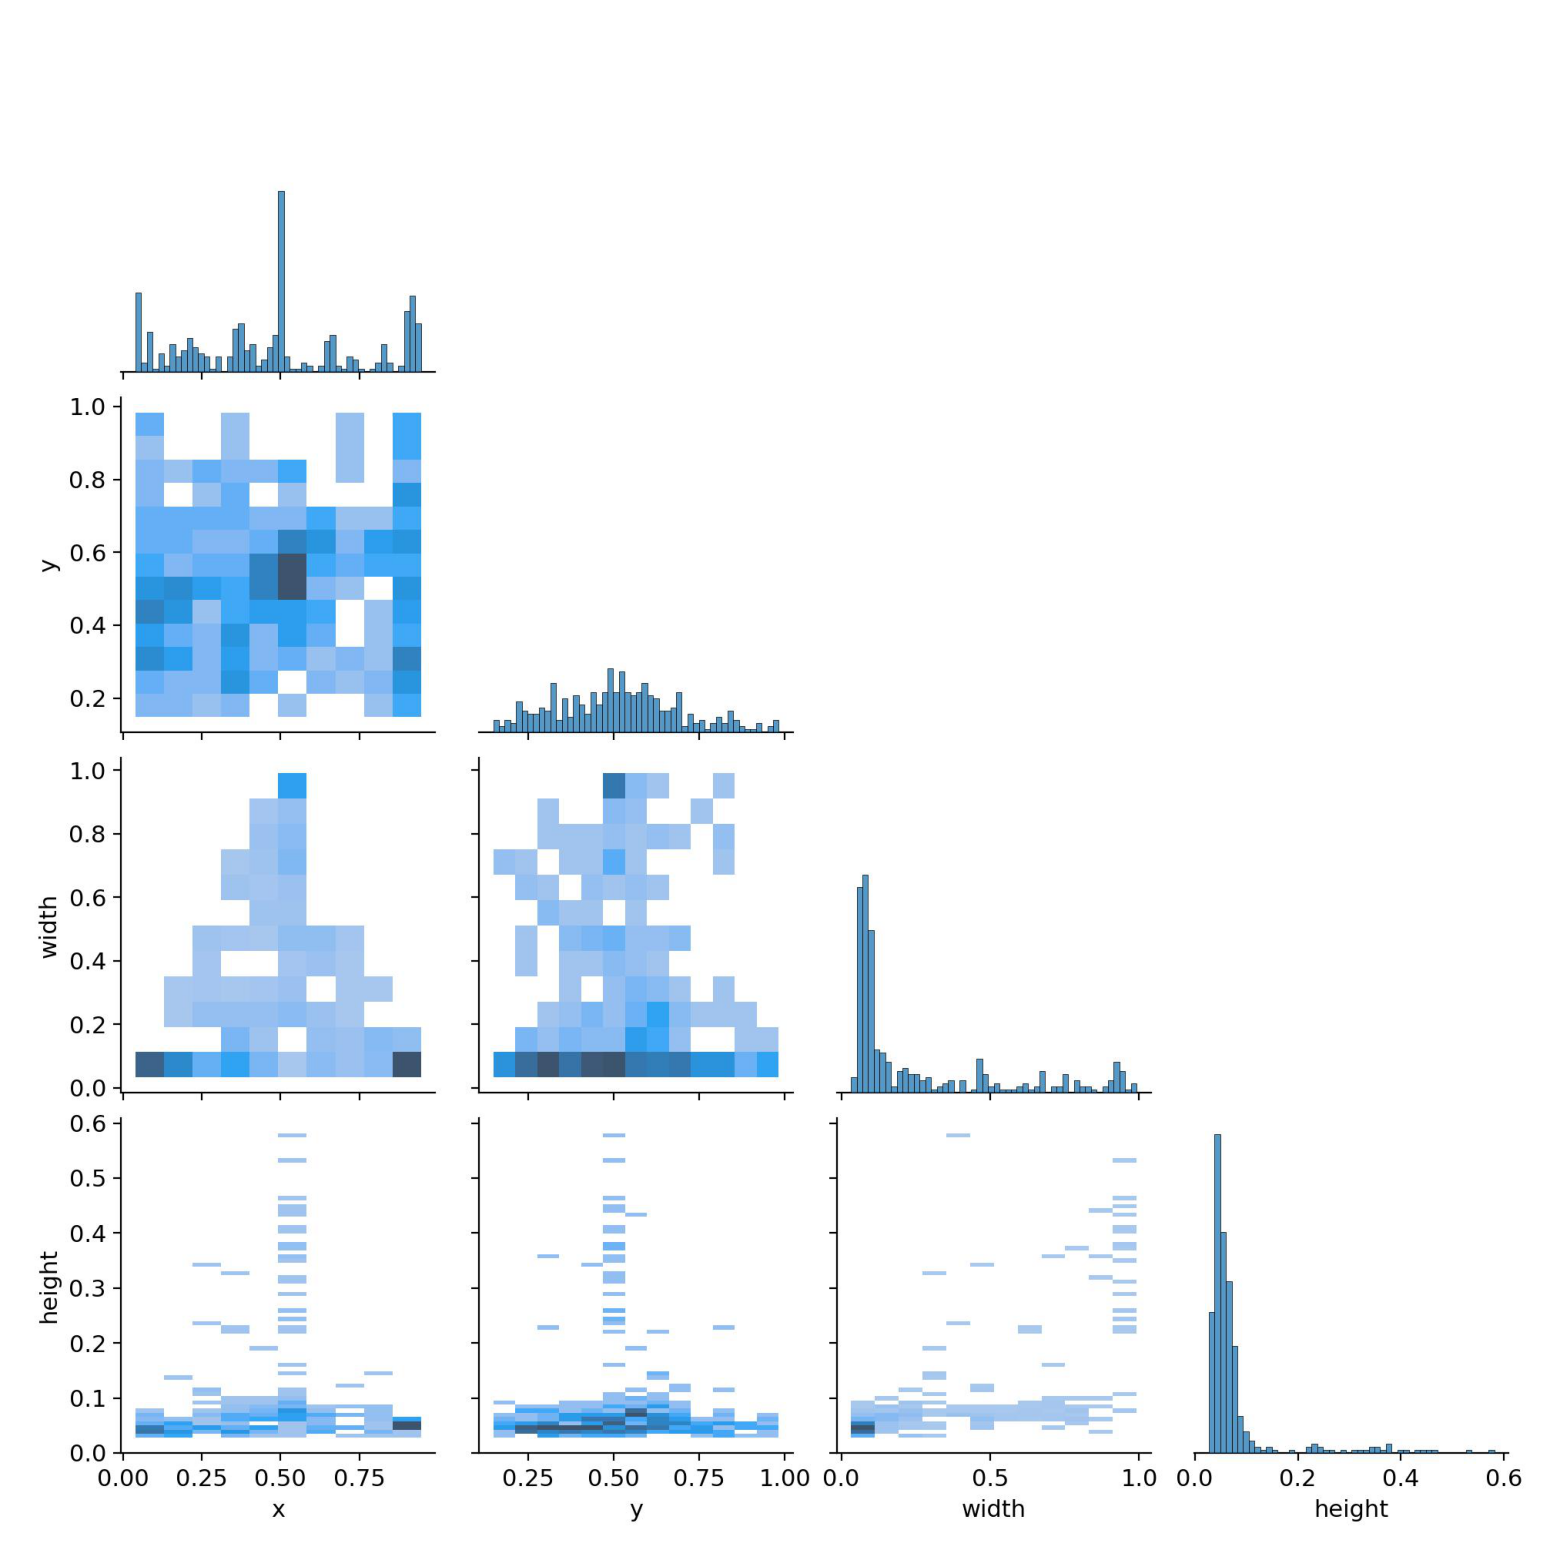

In [ ]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels_correlogram.jpg'));

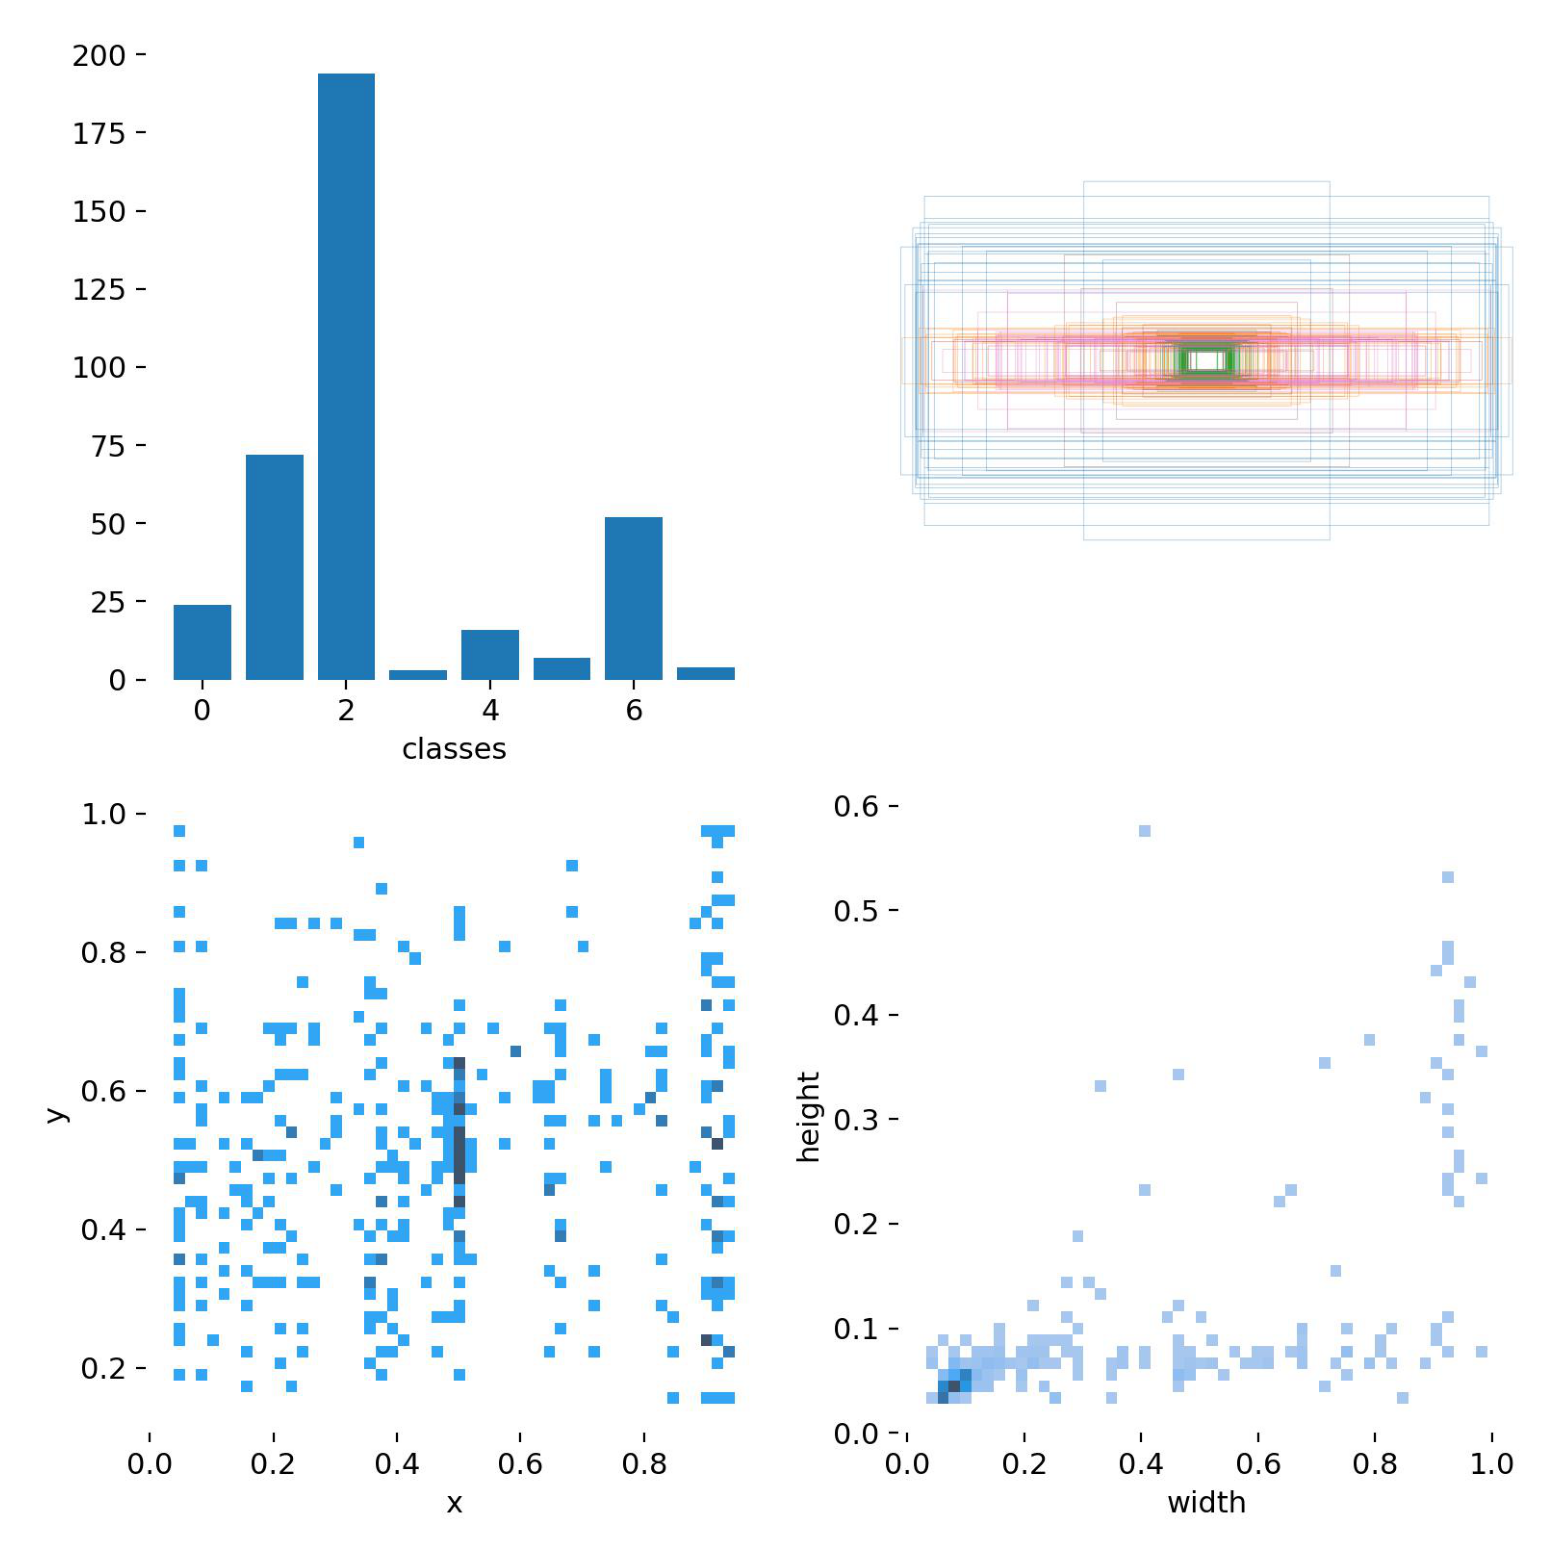

In [ ]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels.jpg'));

0


FileNotFoundError: ignored

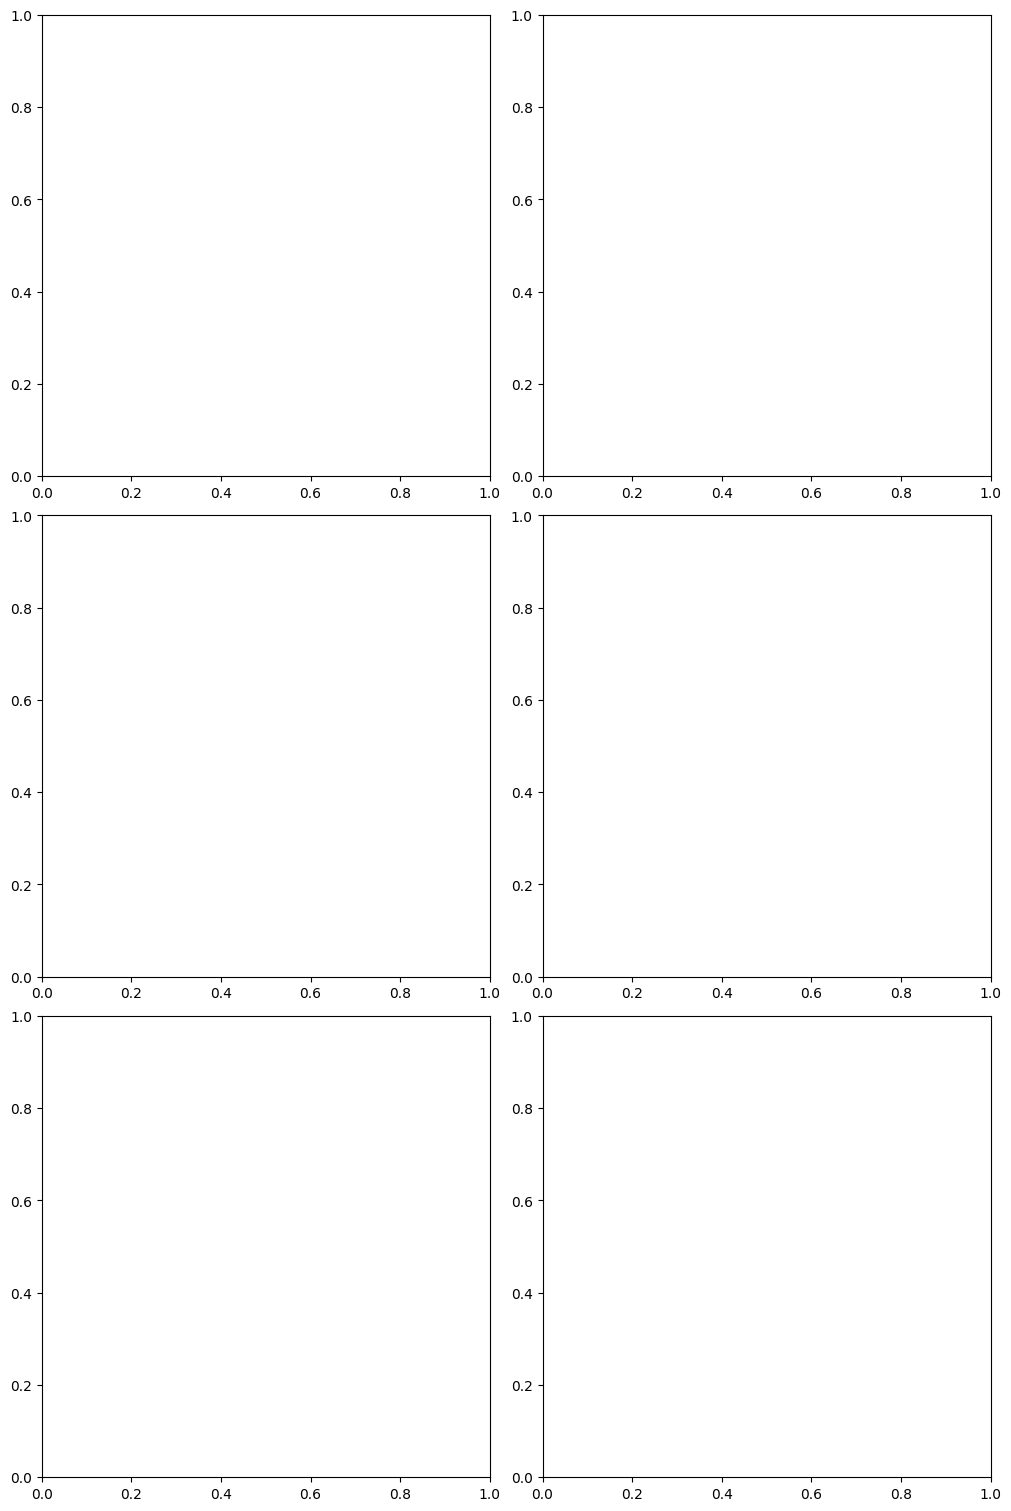

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (2*5,3*5), constrained_layout = True)
for row in range(2):
    print(row)
    ax[row][0].imshow(plt.imread(f'runs/train/exp/test_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'runs/train/exp/test_batch{row}_labels.jpg', fontsize = 12)

    ax[row][1].imshow(plt.imread(f'runs/train/exp/test_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'runs/train/exp/test_batch{row}_pred.jpg', fontsize = 12)